# 1st Runtime

In [ ]:
# import the libraries
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os
import time
LATENT_LENGTH = 2048 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# Load the dataset
dataset_path = "/content/drive/MyDrive/Assignment/Albrecht_Du╠êrer"
batch_size = 8
img_height = 256
img_width = 256

# Create a dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    label_mode=None,
    image_size=(img_height, img_width),
    batch_size=batch_size)

# Preprocessing function
def preprocess(image):
    # Normalize the images to [-1, 1]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) -1
    return image

dataset = dataset.map(preprocess)

Found 328 files belonging to 1 classes.


In [ ]:
with tf.device('/device:GPU:0'):
# Create the generator model
  def make_generator_model():
      model = tf.keras.Sequential()
      model.add(layers.Dense(32*32*3, input_shape=(LATENT_LENGTH,)))
      model.add(layers.BatchNormalization())
      model.add(layers.LeakyReLU())

      model.add(layers.Reshape((32, 32, 3)))

      model.add(layers.Conv2DTranspose(256, (5, 5), strides=(1,1), padding='same'))
      model.add(layers.BatchNormalization())
      model.add(layers.LeakyReLU())

      model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2,2), padding='same'))
      model.add(layers.BatchNormalization())
      model.add(layers.LeakyReLU())

      model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2,2), padding='same'))
      model.add(layers.BatchNormalization())
      model.add(layers.LeakyReLU())

      model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2,2), padding='same', activation='tanh'))

      return model
  generator = make_generator_model()
  generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3072)              6294528   
                                                                 
 batch_normalization (BatchN  (None, 3072)             12288     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 3072)              0         
                                                                 
 reshape (Reshape)           (None, 32, 32, 3)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 256)      19456     
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 256)      1

In [ ]:
with tf.device('/device:GPU:0'):
  # Create the discriminator model
  def make_discriminator_model():
      model = tf.keras.Sequential()
      model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same',
                                      input_shape=[256, 256, 3]))
      model.add(layers.LeakyReLU())
      model.add(layers.Dropout(0.2))

      model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
      model.add(layers.LeakyReLU())
      model.add(layers.Dropout(0.2))

      model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
      model.add(layers.LeakyReLU())
      model.add(layers.Dropout(0.2))

      model.add(layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same'))
      model.add(layers.LeakyReLU())
      model.add(layers.Dropout(0.2))

      model.add(layers.Flatten())
      model.add(layers.Dense(1))

      return model


  discriminator = make_discriminator_model()
  discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 128, 128, 64)      0         
                                                                 
 dropout (Dropout)           (None, 128, 128, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 dropout_1 (Dropout)         (None, 64, 64, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 256)      

In [ ]:
with tf.device('/device:GPU:0'):
  # Define the loss functions and optimizers
  cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

  def generator_loss(fake_output):
      return cross_entropy(tf.ones_like(fake_output), fake_output)

  def discriminator_loss(real_output, fake_output):
      real_loss = cross_entropy(tf.ones_like(real_output), real_output)
      fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
      total_loss = real_loss + fake_loss
      return total_loss

  generator_optimizer = tf.keras.optimizers.Adam(1e-4)
  discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [ ]:
with tf.device('/device:GPU:0'):
  # Define the training loop
  @tf.function
  def train_step(images,epoch):
      # Sample random noise for the generator input
      noise = tf.random.normal([images.shape[0], LATENT_LENGTH],mean=0.0, stddev=1.0)
      
      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
          # Generate new images
          generated_images = generator(noise, training=True)

          # Get the discriminator outputs
          real_output = discriminator(images, training=True)
          fake_output = discriminator(generated_images, training=True)

          # Compute the loss functions
          gen_loss = generator_loss(fake_output)
          disc_loss = discriminator_loss(real_output, fake_output)

      # Compute the gradients and update the parameters
      gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

      # Apply the gradients to the optimizer (Alternate training of the generator and the discriminator)
      if tf.equal(tf.math.mod(epoch, 2), 0): # train discriminator
          discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
      else: # train generator
          generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

      return gen_loss, disc_loss

In [ ]:
# # Train the GAN model
with tf.device('/device:GPU:0'):
  # Train the GAN model
  def train(dataset, epochs):
      for epoch in range(epochs):
          gen_losses = []
          disc_losses = []
          for image_batch in dataset:
              gl, dl = train_step(image_batch,epoch)
              gen_losses.append(gl)
              disc_losses.append(dl)

          # Display the progress
          print("Epoch {}/{} - Generator Loss: {:.4f} - Discriminator Loss: {:.4f}".format(
              epoch + 1, epochs, tf.reduce_mean(gen_losses), tf.reduce_mean(disc_losses)))
          
          # Generate images for testing
          if epoch % 7 == 0:
              noise = tf.random.normal([1, LATENT_LENGTH],mean=0.0, stddev=1.0)
              generated_image = generator(noise, training=False)
              generated_image = tf.squeeze(generated_image, axis=0)
              generated_image = (generated_image + 1) / 2           # Rescale from [-1, 1] to [0, 1]
              plt.imshow(generated_image)
              plt.show()          

            
  # Train the GAN model for 151 epochs
  train(dataset, 151)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Due to resources limit, I will save the model, restart the runtime, then load the models again, and use for training for more epochs
with tf.device('/device:GPU:0'):
  generator.save("/content/drive/MyDrive/Assignment/generator_151_epoch.h5")
  discriminator.save("/content/drive/MyDrive/Assignment/discriminator_151_epoch.h5")

# 2nd Runtime

In [ ]:
# import the libraries
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os
import time
LATENT_LENGTH = 2048 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# Load the dataset
dataset_path = "/content/drive/MyDrive/Assignment/Albrecht_Du╠êrer"
batch_size = 8
img_height = 256
img_width = 256

# Create a dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    label_mode=None,
    image_size=(img_height, img_width),
    batch_size=batch_size)

# Preprocessing function
def preprocess(image):
    # Normalize the images to [-1, 1]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) -1
    return image

dataset = dataset.map(preprocess)

Found 328 files belonging to 1 classes.


In [ ]:
# Load the models from disk
with tf.device('/device:GPU:0'):
  generator = tf.keras.models.load_model("/content/drive/MyDrive/Assignment/generator_151_epoch.h5")
  discriminator = tf.keras.models.load_model("/content/drive/MyDrive/Assignment/discriminator_151_epoch.h5")

In [ ]:
with tf.device('/device:GPU:0'):
  # Define the loss functions and optimizers
  cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

  def generator_loss(fake_output):
      return cross_entropy(tf.ones_like(fake_output), fake_output)

  def discriminator_loss(real_output, fake_output):
      real_loss = cross_entropy(tf.ones_like(real_output), real_output)
      fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
      total_loss = real_loss + fake_loss
      return total_loss

  generator_optimizer = tf.keras.optimizers.Adam(1e-4)
  discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
with tf.device('/device:GPU:0'):
  # Define the training loop
  @tf.function
  def train_step(images,epoch):
      # Sample random noise for the generator input
      noise = tf.random.normal([images.shape[0], LATENT_LENGTH],mean=0.0, stddev=1.0)
      
      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
          # Generate new images
          generated_images = generator(noise, training=True)

          # Get the discriminator outputs
          real_output = discriminator(images, training=True)
          fake_output = discriminator(generated_images, training=True)

          # Compute the loss functions
          gen_loss = generator_loss(fake_output)
          disc_loss = discriminator_loss(real_output, fake_output)

      # Compute the gradients and update the parameters
      gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

      # Apply the gradients to the optimizer
      if tf.equal(tf.math.mod(epoch, 2), 0): # train discriminator
          discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
      else: # train generator
          generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

      return gen_loss, disc_loss

In [ ]:
# # Train the GAN model
with tf.device('/device:GPU:0'):
  # Train the GAN model
  def train(dataset, epochs):
      for epoch in range(epochs):
          gen_losses = []
          disc_losses = []
          for image_batch in dataset:
              gl, dl = train_step(image_batch,epoch)
              gen_losses.append(gl)
              disc_losses.append(dl)

          # Display the progress
          print("Epoch {}/{} - Generator Loss: {:.4f} - Discriminator Loss: {:.4f}".format(
              epoch + 1, epochs, tf.reduce_mean(gen_losses), tf.reduce_mean(disc_losses)))
          
          # Generate images for testing
          if epoch % 7 == 0:
              noise = tf.random.uniform([1, LATENT_LENGTH],minval=-1.0, maxval=1.0)
              generated_image = generator(noise, training=False)
              generated_image = tf.squeeze(generated_image, axis=0)
              generated_image = (generated_image + 1) / 2           # Rescale from [-1, 1] to [0, 1]
              plt.imshow(generated_image)
              plt.show()          

            
  # Train the GAN model for 151 epochs
  train(dataset, 151)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Due to resources limit, I will save the model, restart the runtime, then load the models again, and use for training for more epochs
with tf.device('/device:GPU:0'):
  generator.save("/content/drive/MyDrive/Assignment/generator_302_epoch.h5")
  discriminator.save("/content/drive/MyDrive/Assignment/discriminator_302_epoch.h5")

# 3rd Runtime

In [ ]:
# import the libraries
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os
import time
LATENT_LENGTH = 2048 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# Load the dataset
dataset_path = "/content/drive/MyDrive/Assignment/Albrecht_Du╠êrer"
batch_size = 8
img_height = 256
img_width = 256

# Create a dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    label_mode=None,
    image_size=(img_height, img_width),
    batch_size=batch_size)

# Preprocessing function
def preprocess(image):
    # Normalize the images to [-1, 1]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) -1
    return image

dataset = dataset.map(preprocess)

Found 328 files belonging to 1 classes.


In [ ]:
# Load the models from disk
with tf.device('/device:GPU:0'):
  generator = tf.keras.models.load_model("/content/drive/MyDrive/Assignment/generator_302_epoch.h5")
  discriminator = tf.keras.models.load_model("/content/drive/MyDrive/Assignment/discriminator_302_epoch.h5")

In [ ]:
with tf.device('/device:GPU:0'):
  # Define the loss functions and optimizers
  cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

  def generator_loss(fake_output):
      return cross_entropy(tf.ones_like(fake_output), fake_output)

  def discriminator_loss(real_output, fake_output):
      real_loss = cross_entropy(tf.ones_like(real_output), real_output)
      fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
      total_loss = real_loss + fake_loss
      return total_loss

  generator_optimizer = tf.keras.optimizers.Adam(1e-4)
  discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
with tf.device('/device:GPU:0'):
  # Define the training loop
  @tf.function
  def train_step(images,epoch):
      # Sample random noise for the generator input
      noise = tf.random.normal([images.shape[0], LATENT_LENGTH],mean=0.0, stddev=1.0)
      
      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
          # Generate new images
          generated_images = generator(noise, training=True)

          # Get the discriminator outputs
          real_output = discriminator(images, training=True)
          fake_output = discriminator(generated_images, training=True)

          # Compute the loss functions
          gen_loss = generator_loss(fake_output)
          disc_loss = discriminator_loss(real_output, fake_output)

      # Compute the gradients and update the parameters
      gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

      # Apply the gradients to the optimizer
      if tf.equal(tf.math.mod(epoch, 2), 0): # train discriminator
          discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
      else: # train generator
          generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

      return gen_loss, disc_loss

In [ ]:
# # Train the GAN model
with tf.device('/device:GPU:0'):
  # Train the GAN model
  def train(dataset, epochs):
      for epoch in range(epochs):
          gen_losses = []
          disc_losses = []
          for image_batch in dataset:
              gl, dl = train_step(image_batch,epoch)
              gen_losses.append(gl)
              disc_losses.append(dl)

          # Display the progress
          print("Epoch {}/{} - Generator Loss: {:.4f} - Discriminator Loss: {:.4f}".format(
              epoch + 1, epochs, tf.reduce_mean(gen_losses), tf.reduce_mean(disc_losses)))
          
          # Generate images for testing
          if epoch % 7 == 0:
              noise = tf.random.normal([1, LATENT_LENGTH],mean=0.0, stddev=1.0)
              generated_image = generator(noise, training=False)
              generated_image = tf.squeeze(generated_image, axis=0)
              generated_image = (generated_image + 1) / 2           # Rescale from [-1, 1] to [0, 1]
              plt.imshow(generated_image)
              plt.show()          

            
  # Train the GAN model for 151 epochs
  train(dataset, 151)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Due to resources limit, I will save the model, restart the runtime, then load the models again, and use for training for more epochs
with tf.device('/device:GPU:0'):
  generator.save("/content/drive/MyDrive/Assignment/generator_453_epoch.h5")
  discriminator.save("/content/drive/MyDrive/Assignment/discriminator_453_epoch.h5")

# 4th Runtime

In [ ]:
# import the libraries
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os
import time
LATENT_LENGTH = 2048 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# Load the dataset
dataset_path = "/content/drive/MyDrive/Assignment/Albrecht_Du╠êrer"
batch_size = 8
img_height = 256
img_width = 256

# Create a dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    label_mode=None,
    image_size=(img_height, img_width),
    batch_size=batch_size)

# Preprocessing function
def preprocess(image):
    # Normalize the images to [-1, 1]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) -1
    return image

dataset = dataset.map(preprocess)

Found 328 files belonging to 1 classes.


In [ ]:
# Load the models from disk
with tf.device('/device:GPU:0'):
  generator = tf.keras.models.load_model("/content/drive/MyDrive/Assignment/generator_453_epoch.h5")
  discriminator = tf.keras.models.load_model("/content/drive/MyDrive/Assignment/discriminator_453_epoch.h5")

In [ ]:
with tf.device('/device:GPU:0'):
  # Define the loss functions and optimizers
  cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

  def generator_loss(fake_output):
      return cross_entropy(tf.ones_like(fake_output), fake_output)

  def discriminator_loss(real_output, fake_output):
      real_loss = cross_entropy(tf.ones_like(real_output), real_output)
      fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
      total_loss = real_loss + fake_loss
      return total_loss

  generator_optimizer = tf.keras.optimizers.Adam(1e-4)
  discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
with tf.device('/device:GPU:0'):
  # Define the training loop
  @tf.function
  def train_step(images,epoch):
      # Sample random noise for the generator input
      noise = tf.random.normal([images.shape[0], LATENT_LENGTH],mean=0.0, stddev=1.0)
      
      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
          # Generate new images
          generated_images = generator(noise, training=True)

          # Get the discriminator outputs
          real_output = discriminator(images, training=True)
          fake_output = discriminator(generated_images, training=True)

          # Compute the loss functions
          gen_loss = generator_loss(fake_output)
          disc_loss = discriminator_loss(real_output, fake_output)

      # Compute the gradients and update the parameters
      gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

      # Apply the gradients to the optimizer
      if tf.equal(tf.math.mod(epoch, 2), 0): # train discriminator
          discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
      else: # train generator
          generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

      return gen_loss, disc_loss

In [ ]:
# # Train the GAN model
with tf.device('/device:GPU:0'):
  # Train the GAN model
  def train(dataset, epochs):
      for epoch in range(epochs):
          gen_losses = []
          disc_losses = []
          for image_batch in dataset:
              gl, dl = train_step(image_batch,epoch)
              gen_losses.append(gl)
              disc_losses.append(dl)

          # Display the progress
          print("Epoch {}/{} - Generator Loss: {:.4f} - Discriminator Loss: {:.4f}".format(
              epoch + 1, epochs, tf.reduce_mean(gen_losses), tf.reduce_mean(disc_losses)))
          
          # Generate images for testing
          if epoch % 7 == 0:
              noise = tf.random.normal([1, LATENT_LENGTH],mean=0.0, stddev=1.0)
              generated_image = generator(noise, training=False)
              generated_image = tf.squeeze(generated_image, axis=0)
              generated_image = (generated_image + 1) / 2           # Rescale from [-1, 1] to [0, 1]
              plt.imshow(generated_image)
              plt.show()          

            
  # Train the GAN model for 247 more epochs
  train(dataset, 247)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Due to resources limit, I will save the model, restart the runtime, then load the models again, and use for training for more epochs
with tf.device('/device:GPU:0'):
  generator.save("/content/drive/MyDrive/Assignment/generator_700_epoch.h5")
  discriminator.save("/content/drive/MyDrive/Assignment/discriminator_700_epoch.h5")

# 5th Runtime

In [ ]:
# import the libraries
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os
import time
LATENT_LENGTH = 2048 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# Load the dataset
dataset_path = "/content/drive/MyDrive/Assignment/Albrecht_Du╠êrer"
batch_size = 8
img_height = 256
img_width = 256

# Create a dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    label_mode=None,
    image_size=(img_height, img_width),
    batch_size=batch_size)

# Preprocessing function
def preprocess(image):
    # Normalize the images to [-1, 1]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) -1
    return image

dataset = dataset.map(preprocess)

Found 328 files belonging to 1 classes.


In [ ]:
# Load the models from disk
with tf.device('/device:GPU:0'):
  generator = tf.keras.models.load_model("/content/drive/MyDrive/Assignment/generator_700_epoch.h5")
  discriminator = tf.keras.models.load_model("/content/drive/MyDrive/Assignment/discriminator_700_epoch.h5")

In [ ]:
with tf.device('/device:GPU:0'):
  # Define the loss functions and optimizers
  cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

  def generator_loss(fake_output):
      return cross_entropy(tf.ones_like(fake_output), fake_output)

  def discriminator_loss(real_output, fake_output):
      real_loss = cross_entropy(tf.ones_like(real_output), real_output)
      fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
      total_loss = real_loss + fake_loss
      return total_loss

  generator_optimizer = tf.keras.optimizers.Adam(1e-4)
  discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
with tf.device('/device:GPU:0'):
  # Define the training loop
  @tf.function
  def train_step(images,epoch):
      # Sample random noise for the generator input
      noise = tf.random.normal([images.shape[0], LATENT_LENGTH],mean=0.0, stddev=1.0)
      
      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
          # Generate new images
          generated_images = generator(noise, training=True)

          # Get the discriminator outputs
          real_output = discriminator(images, training=True)
          fake_output = discriminator(generated_images, training=True)

          # Compute the loss functions
          gen_loss = generator_loss(fake_output)
          disc_loss = discriminator_loss(real_output, fake_output)

      # Compute the gradients and update the parameters
      gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

      # Apply the gradients to the optimizer
      if tf.equal(tf.math.mod(epoch, 2), 0): # train discriminator
          discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
      else: # train generator
          generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

      return gen_loss, disc_loss

In [ ]:
# # Train the GAN model
with tf.device('/device:GPU:0'):
  # Train the GAN model
  def train(dataset, epochs):
      for epoch in range(epochs):
          gen_losses = []
          disc_losses = []
          for image_batch in dataset:
              gl, dl = train_step(image_batch,epoch)
              gen_losses.append(gl)
              disc_losses.append(dl)

          # Display the progress
          print("Epoch {}/{} - Generator Loss: {:.4f} - Discriminator Loss: {:.4f}".format(
              epoch + 1, epochs, tf.reduce_mean(gen_losses), tf.reduce_mean(disc_losses)))
          
          # Generate images for testing
          if epoch % 7 == 0:
              noise = tf.random.normal([1, LATENT_LENGTH],mean=0.0, stddev=1.0)
              generated_image = generator(noise, training=False)
              generated_image = tf.squeeze(generated_image, axis=0)
              generated_image = (generated_image + 1) / 2           # Rescale from [-1, 1] to [0, 1]
              plt.imshow(generated_image)
              plt.show()          

            
  # Train the GAN model for 300 more epochs
  train(dataset, 300)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Due to resources limit, I will save the model, restart the runtime, then load the models again, and use for training for more epochs
with tf.device('/device:GPU:0'):
  generator.save("/content/drive/MyDrive/Assignment/generator_1000_epoch.h5")
  discriminator.save("/content/drive/MyDrive/Assignment/discriminator_1000_epoch.h5")

# 6th Runtime

In [ ]:
# import the libraries
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os
import time
LATENT_LENGTH = 2048 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# Load the dataset
dataset_path = "/content/drive/MyDrive/Assignment/Albrecht_Du╠êrer"
batch_size = 8
img_height = 256
img_width = 256

# Create a dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    label_mode=None,
    image_size=(img_height, img_width),
    batch_size=batch_size)

# Preprocessing function
def preprocess(image):
    # Normalize the images to [-1, 1]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) -1
    return image

dataset = dataset.map(preprocess)

Found 328 files belonging to 1 classes.


In [ ]:
# Load the models from disk
with tf.device('/device:GPU:0'):
  generator = tf.keras.models.load_model("/content/drive/MyDrive/Assignment/generator_1000_epoch.h5")
  discriminator = tf.keras.models.load_model("/content/drive/MyDrive/Assignment/discriminator_1000_epoch.h5")

In [ ]:
with tf.device('/device:GPU:0'):
  # Define the loss functions and optimizers
  cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

  def generator_loss(fake_output):
      return cross_entropy(tf.ones_like(fake_output), fake_output)

  def discriminator_loss(real_output, fake_output):
      real_loss = cross_entropy(tf.ones_like(real_output), real_output)
      fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
      total_loss = real_loss + fake_loss
      return total_loss

  generator_optimizer = tf.keras.optimizers.Adam(1e-4)
  discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
with tf.device('/device:GPU:0'):
  # Define the training loop
  @tf.function
  def train_step(images,epoch):
      # Sample random noise for the generator input
      noise = tf.random.normal([images.shape[0], LATENT_LENGTH],mean=0.0, stddev=1.0)
      
      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
          # Generate new images
          generated_images = generator(noise, training=True)

          # Get the discriminator outputs
          real_output = discriminator(images, training=True)
          fake_output = discriminator(generated_images, training=True)

          # Compute the loss functions
          gen_loss = generator_loss(fake_output)
          disc_loss = discriminator_loss(real_output, fake_output)

      # Compute the gradients and update the parameters
      gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

      # Apply the gradients to the optimizer
      if tf.equal(tf.math.mod(epoch, 2), 0): # train discriminator
          discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
      else: # train generator
          generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

      return gen_loss, disc_loss

In [ ]:
# # Train the GAN model
with tf.device('/device:GPU:0'):
  # Train the GAN model
  def train(dataset, epochs):
      for epoch in range(epochs):
          gen_losses = []
          disc_losses = []
          for image_batch in dataset:
              gl, dl = train_step(image_batch,epoch)
              gen_losses.append(gl)
              disc_losses.append(dl)

          # Display the progress
          print("Epoch {}/{} - Generator Loss: {:.4f} - Discriminator Loss: {:.4f}".format(
              epoch + 1, epochs, tf.reduce_mean(gen_losses), tf.reduce_mean(disc_losses)))
          
          # Generate images for testing
          if epoch % 7 == 0:
              noise = tf.random.normal([1, LATENT_LENGTH],mean=0.0, stddev=1.0)
              generated_image = generator(noise, training=False)
              generated_image = tf.squeeze(generated_image, axis=0)
              generated_image = (generated_image + 1) / 2           # Rescale from [-1, 1] to [0, 1]
              plt.imshow(generated_image)
              plt.show()          

            
  # Train the GAN model for 300 more epochs
  train(dataset, 300)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Due to resources limit, I will save the model, restart the runtime, then load the models again, and use for training for more epochs
with tf.device('/device:GPU:0'):
  generator.save("/content/drive/MyDrive/Assignment/generator_1300_epoch.h5")
  discriminator.save("/content/drive/MyDrive/Assignment/discriminator_1300_epoch.h5")

# 7th Runtime

In [1]:
# import the libraries
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os
import time
LATENT_LENGTH = 2048 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
# Load the dataset
dataset_path = "/content/drive/MyDrive/Assignment/Albrecht_Du╠êrer"
batch_size = 8
img_height = 256
img_width = 256

# Create a dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    label_mode=None,
    image_size=(img_height, img_width),
    batch_size=batch_size)

# Preprocessing function
def preprocess(image):
    # Normalize the images to [-1, 1]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) -1
    return image

dataset = dataset.map(preprocess)

Found 328 files belonging to 1 classes.


In [5]:
# Load the models from disk
with tf.device('/device:GPU:0'):
  generator = tf.keras.models.load_model("/content/drive/MyDrive/Assignment/generator_1300_epoch.h5")
  discriminator = tf.keras.models.load_model("/content/drive/MyDrive/Assignment/discriminator_1300_epoch.h5")

In [6]:
with tf.device('/device:GPU:0'):
  # Define the loss functions and optimizers
  cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

  def generator_loss(fake_output):
      return cross_entropy(tf.ones_like(fake_output), fake_output)

  def discriminator_loss(real_output, fake_output):
      real_loss = cross_entropy(tf.ones_like(real_output), real_output)
      fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
      total_loss = real_loss + fake_loss
      return total_loss

  generator_optimizer = tf.keras.optimizers.Adam(1e-4)
  discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [7]:
with tf.device('/device:GPU:0'):
  # Define the training loop
  @tf.function
  def train_step(images,epoch):
      # Sample random noise for the generator input
      noise = tf.random.normal([images.shape[0], LATENT_LENGTH],mean=0.0, stddev=1.0)
      
      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
          # Generate new images
          generated_images = generator(noise, training=True)

          # Get the discriminator outputs
          real_output = discriminator(images, training=True)
          fake_output = discriminator(generated_images, training=True)

          # Compute the loss functions
          gen_loss = generator_loss(fake_output)
          disc_loss = discriminator_loss(real_output, fake_output)

      # Compute the gradients and update the parameters
      gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

      # Apply the gradients to the optimizer
      if tf.equal(tf.math.mod(epoch, 2), 0): # train discriminator
          discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
      else: # train generator
          generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

      return gen_loss, disc_loss

In [8]:
# # Train the GAN model
with tf.device('/device:GPU:0'):
  # Train the GAN model
  def train(dataset, epochs):
      for epoch in range(epochs):
          gen_losses = []
          disc_losses = []
          for image_batch in dataset:
              gl, dl = train_step(image_batch,epoch)
              gen_losses.append(gl)
              disc_losses.append(dl)

          # Display the progress
          print("Epoch {}/{} - Generator Loss: {:.4f} - Discriminator Loss: {:.4f}".format(
              epoch + 1, epochs, tf.reduce_mean(gen_losses), tf.reduce_mean(disc_losses)))
          
          # Generate images for testing
          if epoch % 7 == 0:
              noise = tf.random.normal([1, LATENT_LENGTH],mean=0.0, stddev=1.0)
              generated_image = generator(noise, training=False)
              generated_image = tf.squeeze(generated_image, axis=0)
              generated_image = (generated_image + 1) / 2           # Rescale from [-1, 1] to [0, 1]
              plt.imshow(generated_image)
              plt.show()          

            
  # Train the GAN model for 200 more epochs
  train(dataset, 200)

Output hidden; open in https://colab.research.google.com to view.

In [14]:
# Due to resources limit, I will save the model, restart the runtime, then load the models again, and use for training for more epochs
with tf.device('/device:GPU:0'):
  generator.save("/content/drive/MyDrive/Assignment/generator_1500_epoch.h5")
  discriminator.save("/content/drive/MyDrive/Assignment/discriminator_1500_epoch.h5")

# Testing

In [67]:
# import the libraries
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
LATENT_LENGTH = 2048 
img_height = 256
img_width = 256

In [68]:
# Define the function to generate and save new images using the trained generator model
def generate_images(model,img, test_input, save_path, prefix):
    # Generate the predictions
    predictions = model(test_input, training=False)
    # Create the output directory if it doesn't exist
    os.makedirs(save_path, exist_ok=True)
    # Display and Save each image to disk
    predictions = (predictions+1)/2
    for i in range(predictions.shape[0]):
      # merge the original with random generated art(predictions)
        plt.imshow((2*predictions[i] +img)/3)     # giving double importance to the predicted art 
        # Convert the image to a PIL image and save it to disk
        image = tf.keras.preprocessing.image.array_to_img((2*predictions[i] +img)/3)
        filename = os.path.join(save_path, f'{prefix}_{i}.jpg')
        image.save(filename)
        plt.show()

In [91]:
generator = tf.keras.models.load_model("/content/drive/MyDrive/Assignment/generator_1500_epoch.h5")

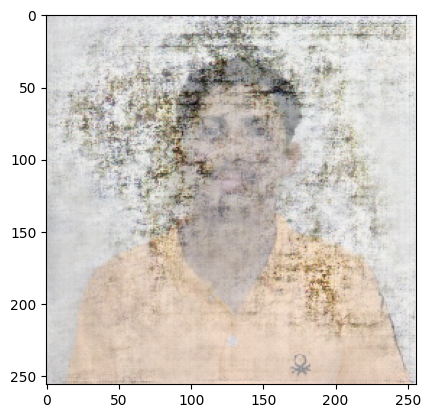

In [92]:
# Load an image file as the test input
test_image_path = '/content/drive/MyDrive/Assignment/Munna_Ram .jpg'
test_image = tf.keras.preprocessing.image.load_img(test_image_path, target_size=(img_height, img_width))
test_image = tf.keras.preprocessing.image.img_to_array(test_image)
test_image = (test_image/ 255) # Normalize the pixel values to [0, 1]
# test_image = tf.expand_dims(test_image,axis=0)
noise = tf.random.normal([1, LATENT_LENGTH],mean=0.0, stddev=1.0)
# Generate style transfered image for input image
generate_images(generator, test_image,noise, "/content/drive/MyDrive/Assignment/output", "Munna_Ram")

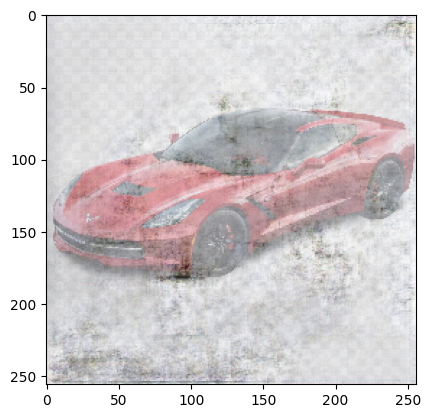

In [93]:
# Load an image file as the test input
test_image_path = '/content/drive/MyDrive/Assignment/Car.jpg'
test_image = tf.keras.preprocessing.image.load_img(test_image_path, target_size=(img_height, img_width))
test_image = tf.keras.preprocessing.image.img_to_array(test_image)
test_image = (test_image/ 255) # Normalize the pixel values to [0, 1]
# test_image = tf.expand_dims(test_image,axis=0)
noise = tf.random.normal([1, LATENT_LENGTH],mean=0.0, stddev=1.0)
# Generate style transfered image for input image
generate_images(generator, test_image,noise, "/content/drive/MyDrive/Assignment/output", "Car")